In [1]:
import os
import os.path
import pickle as pkl
import sys

import numpy as np
import torch
from torch.utils.data import Dataset
from matplotlib import image
import fnmatch
from pathlib import Path
import glob
import time

sys.path.append('../')

import utils
import tforms
# import src.utils as utils



<AxesSubplot:>

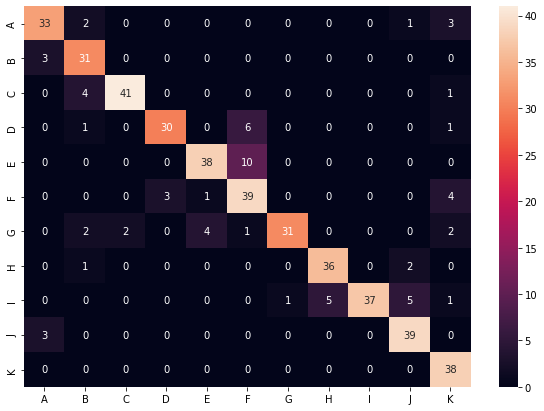

In [1]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[33,2,0,0,0,0,0,0,0,1,3], 
        [3,31,0,0,0,0,0,0,0,0,0], 
        [0,4,41,0,0,0,0,0,0,0,1], 
        [0,1,0,30,0,6,0,0,0,0,1], 
        [0,0,0,0,38,10,0,0,0,0,0], 
        [0,0,0,3,1,39,0,0,0,0,4], 
        [0,2,2,0,4,1,31,0,0,0,2],
        [0,1,0,0,0,0,0,36,0,2,0], 
        [0,0,0,0,0,0,1,5,37,5,1], 
        [3,0,0,0,0,0,0,0,0,39,0], 
        [0,0,0,0,0,0,0,0,0,0,38]]
df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"],
                  columns = [i for i in "ABCDEFGHIJK"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [2]:


def loadExperiments_cifar10(experiment_filepath):
    tasks_filepaths_train = glob.glob('%s/train/*.npy'%(experiment_filepath))
    tasks_filepaths_train.sort(key=utils.natural_keys)
    tasks_filepaths_test = glob.glob('%s/test/*.npy'%(experiment_filepath))
    tasks_filepaths_test.sort(key=utils.natural_keys)
    return tasks_filepaths_train, tasks_filepaths_test




def cifar10tasks(num_per_class, first_task_num=None, shuffle=False):
    '''
    if 10 is not divisible by num_per_class, then make extra classes go into first task. 
    '''
    num_classes = 10
    classes = np.arange(0,num_classes,1)
    rest= 10%num_per_class
    if shuffle:
        classes = classes[np.random.permutation(10)]
    classes = list(classes)

    if first_task_num is not None:
        first_task=classes[:first_task_num]
    else:
        first_task = classes[:(num_per_class+rest)]
    other_tasks = utils.list_to_2D(classes[len(first_task):],num_per_class)
    tasks = [first_task]+other_tasks

    return tasks
    


def load_cifar(root, dname='cifar10', train=True):
    
    if dname=='cifar10':
        base_folder = 'cifar-10-batches-py'
        train_list = [
            ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
            ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
            ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
            ['data_batch_4', '634d18415352ddfa80567beed471001a'],
            ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
        ]

        test_list = [
            ['test_batch', '40351d587109b95175f43aff81a1287e'],
        ]
    elif dname=='cifar100':
        base_folder = 'cifar-100-python'
        train_list = [
            ['train', '16019d7e3df5f24257cddd939b257f8d'],
        ]

        test_list = [
            ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
        ]

    root = os.path.expanduser(root)

    if train:
        downloaded_list = train_list
    else:
        downloaded_list = test_list

    data = []
    labels = []

    # now load the picked numpy arrays
    for file_name, checksum in downloaded_list:
        file_path = os.path.join(root, base_folder, file_name)
        with open(file_path, 'rb') as f:
            if sys.version_info[0] == 2:
                entry = pkl.load(f)
            else:
                entry = pkl.load(f, encoding='latin1')
            data.append(entry['data'])
            if 'labels' in entry:
                labels.extend(entry['labels'])
            else:
                labels.extend(entry['fine_labels'])

    data = np.vstack(data).reshape(-1, 3, 32, 32)
    data = data.transpose((0, 2, 3, 1))  # convert to HWC

    data = np.array(data)
    labels = np.array(labels)
    data = np.transpose(data, (0, 3, 1, 2))
    data = torch.from_numpy(data)
    # y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    labels = torch.from_numpy(labels).type(torch.LongTensor)
    
    return data, labels
            


def cifar10Experiments_w_holdout(labels_per_task, dataroot, outdir, experiment_name, holdout_percent=0.25, max_holdout=0.75, partition='train'):
    """ 
    CORe50 Experiments setup
    Args:
        root (string): Root directory of the dataset where images and paths file are stored
        outdir (string): Out directory to store experiment task files (txt sequences of objects)
        train (bool, optional): partition set. If train=True then it is train set. Else, test. 
        scenario (string, optional): What tye of CL learning regime. 'nc' stands for class incremental,\
             where each task contains disjoint class subsets
        run (int, optional):  with different runs shuffle order of tasks.
    """
    
    # root = os.path.expanduser(root)
    dataroot = Path(dataroot)
    data, labels = load_cifar(dataroot, dname='cifar10', train=True)
    data = data.numpy()
    labels = labels.numpy()
    num_samples = data.shape[0]
    indices = np.arange(0,num_samples)


    # --- Set up Task sequences (seq of labels)
    tasks_list=[]
    tasks_list_holdout = []
    for task in labels_per_task:
        tasks_list.append([])
        tasks_list_holdout.append([])
        for lb in task:
            tasks_list[-1].extend(list(np.where(labels==lb)[0]))
        tasks_list[-1] = np.array(tasks_list[-1])
        size_task = tasks_list[-1].shape[0]
        if holdout_percent>0:
            size_holdout = int(size_task*min(holdout_percent, max_holdout))
            inds_all = np.arange(size_task)
            indices_holdout = np.random.permutation(inds_all)[:size_holdout]
            indices_keep = np.array(list(set(list(inds_all)) - set(list(indices_holdout))))
            tasks_list_holdout[-1] = tasks_list[-1][indices_holdout]
            tasks_list[-1] = tasks_list[-1][indices_keep]
        

    # --- save sequences to text files 
    dest_dir = '%s/%s/%s'%(outdir,'cifar10', experiment_name)
    utils.makedirectory(dest_dir)
    dest_dir_keep = dest_dir + '/%s'%(partition)
    utils.makedirectory(dest_dir_keep)
    if holdout_percent>0:
        dest_dir_holdout = dest_dir + '/%s'%('holdout')
        utils.makedirectory(dest_dir_holdout)

    # Create directory for experiment 
    task_filepaths=[]
    task_filepaths_holdout=[]
    for task in range(len(tasks_list)):
        task_filepaths.append("%s/%s_%s_task_%d.npy"%(dest_dir_keep, 'nc', partition, task))
        np.save(task_filepaths[-1], tasks_list[task])
        if holdout_percent>0:
            task_filepaths_holdout.append("%s/%s_%s_task_%d.npy"%(dest_dir_holdout, 'nc', 'holdout', task))
            np.save(task_filepaths_holdout[-1], tasks_list_holdout[task])


    return task_filepaths, task_filepaths_holdout
        



In [3]:
# cifar10Experiments_w_holdout([[0,1]], '../../data/cifar10', './results',  'tryout', holdout_percent=0, partition='test')

In [4]:
# make script to call datasets (all so far)
def call_dataset_holdout(dset_name, data_dir, experiment_dir, experiment_filepath=None, 
                                            experiment_name=None, holdout_percent=0.25,  max_holdout=0.75, scenario='nc', 
                                            scenario_classif='class', exp_type='class', num_per_task=1, num_classes_first=2, 
                                            shuffle=False, preload=False):

    start = time.time()

    if dset_name=='cifar10':
        import cifar10_dataset as dset
        total_classes=10
        obj2class={}
        for i in range(0,10):
            obj2class[i]=i
        dset_prep={'total_classes':total_classes, 'scenario_classif':-1, 'obj2class':obj2class,\
            'dataset_wrap':'cifar10Task', 'transform_train_name':'cifar_train', \
            'transform_test_name':'cifar_test',  'tasks_gen':'cifar10tasks', 'experiment_gen':'cifar10Experiments_w_holdout',\
                'load_experiments':'loadExperiments_cifar10'}
        # Generate sequence of classes for experiment 
        seq_tasks = dset.cifar10tasks(num_per_task, first_task_num=num_classes_first, shuffle=shuffle)
    elif dset_name=='core50':
        import core50_dataset as dset
        total_classes = {'class':10, 'instance':50}
        # Generate sequence of classes for experiment 
        obj2class = dset.Core50_classdict()
        total_classes = total_classes[scenario_classif]
        seq_tasks = dset.core50tasks(scenario,  exp_type=exp_type, num_classes_first=num_classes_first, num_class_per_task=num_per_task, shuffle=shuffle)
        if scenario_classif=='class':
            target_ind=-1
        elif scenario_classif=='instance':
            target_ind=-2
        dset_prep={'total_classes':total_classes,  'scenario_classif':target_ind, 'obj2class':obj2class, 'dataset_wrap':'core50Task', \
            'transform_train_name':'core50_train', 'transform_test_name':'core50_test',\
                'tasks_gen':'core50tasks', 'experiment_gen':'core50Experiments_w_holdout',  \
                'load_experiments':'loadExperiments_core50'}
        
    print('seq_tasks: ', seq_tasks)

    print('*****Prep Data*****')
    data_dir = '%s/%s'%(data_dir, dset_name)
    # if args.experiment_filepath:
    if experiment_filepath is not None:
        if os.path.exists(experiment_filepath):
            tasks_filepaths_train, tasks_filepaths_test = dset.__getattribute__(dset_prep['load_experiments'])(experiment_filepath)
            # list_tasks = dset.__getattribute__(dset_prep['tasks_gen'])(scenario)
    else:
        try:
            assert experiment_name is not None
        except:
            print('Need to give experiment a name: set args.experiment_name as a string')
            sys.exit()
        tasks_filepaths_train, tasks_filepaths_train_holdout = dset.__getattribute__(dset_prep['experiment_gen'])(seq_tasks, data_dir, \
            experiment_dir, experiment_name, holdout_percent=holdout_percent, max_holdout=max_holdout, partition='train')
        tasks_filepaths_test,_ = dset.__getattribute__(dset_prep['experiment_gen'])(seq_tasks, data_dir, \
            experiment_dir, experiment_name, holdout_percent=0, max_holdout=max_holdout, partition='test')
        print('prepared filelists', time.time()-start)


    print(experiment_filepath)
    num_tasks = len(tasks_filepaths_train)
    print('number tasks', num_tasks)

    if preload:
        transform_train=None
        transform_test=None
    else:
        transform_train =  tforms.__getattribute__(dset_prep['transform_train_name'])()
        transform_test =  tforms.__getattribute__(dset_prep['transform_test_name'])()

    train_datasets = [dset.__getattribute__(dset_prep['dataset_wrap'])(data_dir, tasklist=tasks_filepaths_train[i], preload=preload, \
        transform=transform_train) for i in range(num_tasks)]

    if len(tasks_filepaths_train_holdout):
        train_holdout_datasets = [dset.__getattribute__(dset_prep['dataset_wrap'])(data_dir, tasklist=tasks_filepaths_train_holdout[i], preload=preload, \
            transform=transform_train) for i in range(num_tasks)]
    else:
        train_holdout_datasets=[]

    test_datasets = [dset.__getattribute__(dset_prep['dataset_wrap'])(data_dir, tasklist=tasks_filepaths_test[i], preload=preload, \
        transform=transform_test) for i in range(num_tasks)]

    print('prepared datasets', time.time()-start)

    return train_datasets, train_holdout_datasets, test_datasets, seq_tasks, dset_prep



In [5]:


all_dsets = call_dataset_holdout('cifar10',  '../../data', './experiments', experiment_filepath=None, 
                                            experiment_name='tryout', holdout_percent=0.25,  max_holdout=0.75, scenario='nc', 
                                            scenario_classif='class', exp_type='class', num_per_task=1, num_classes_first=2, 
                                            shuffle=False, preload=False)

train_datasets, train_holdout_datasets, test_datasets, seq_tasks, dset_prep = all_dsets

seq_tasks:  [[0, 1], [2], [3], [4], [5], [6], [7], [8], [9]]
*****Prep Data*****
prepared filelists 0.6772854328155518
None
number tasks 9
prepared datasets 8.645753383636475


In [6]:



class cifar10Task():
    def __init__(self, dataroot, train=True, tasklist='task_indices.npy', transform=None, returnIDX=False, preload=True):
        """ 
        dataset for each individual task
        """
        data, labels = load_cifar(dataroot, dname='cifar10', train=train)
        self.indices_task_init = np.load(tasklist)

        self.x = data 
        self.y = labels 
        self.transform = transform
        self.preload = preload 
        self.returnIDX = returnIDX
        
        # get appropriate task data
        self.x = self.x[self.indices_task_init, ...]
        self.y = self.y[self.indices_task_init]
        self.indices_task_init = np.arange(self.indices_task_init.shape[0])
        self.indices_task = np.copy(self.indices_task_init)

    def __len__(self):
        return self.indices_task.shape[0]

    def select_random_subset(self, random_num):

        inds_keep = np.random.permutation(np.arange(self.indices_task_init.shape[0]))[:random_num]

        self.indices_task = self.indices_task_init[inds_keep]

        
    def __getitem__(self, idx):

        idx = self.indices_task[idx]

        im = self.x[idx,...]
        
        if self.transform is not None: ##input the desired tranform 

            im = self.transform(im)

        class_lbl = self.y[idx]

        if self.returnIDX:
            return im, class_lbl, class_lbl, idx
            
        return im, class_lbl, class_lbl

class core50Task(Dataset):
    def __init__(self, root, tasklist='tasklist.txt', preload=True, transform=None, returnIDX=False):
        """ 
        CORe50 Pytorch Dataset wrapper for each task
        Args:
            root (string): Root directory of the dataset where images and paths file are stored
            tasklist (string): filepath for paths of images belonging to a given task as well as the label of the object. 
            preload (bool, optional): If True data is pre-loaded with look-up
                tables. RAM usage may be high.
            multilabel (bool): If outputting more then one label per input 
        """
        self.root = Path(root)
        self.preload = preload
        self.tasklist = tasklist
        self.transform = transform
        self.returnIDX = returnIDX

        self.x_paths=[]
        self.y = [[],[]]
        if os.path.exists(self.tasklist):
            with open(self.tasklist, 'r') as f:
                for line in f:
                    obj_path, obj, lbl_obj = line.rstrip().split(' ')
                    self.y[0].append(obj)
                    self.y[1].append(lbl_obj)
                    self.x_paths.append(obj_path)
        else:
            print('not found path')
        self.y = np.array(self.y).astype('int')
        self.y = torch.from_numpy(self.y)

        self.indices_task_init = np.arange(self.y.shape[1])
        self.indices_task = np.copy(self.indices_task_init)

        if self.preload:
            # print("Loading data...")
            self.x = np.zeros((self.y.shape[1], 3, 128, 128))
            # self.x = np.zeros((len(self.y), 128, 128, 3))
            for i, path_ in enumerate(self.x_paths):
                # raw = image.imread(self.root / 'images'/ path_)
                raw = utils.image2arr(self.root / 'images'/ path_)
                self.x[i,...] = raw

            self.x = self.x / 255
            self.x[:, 0, :, :] = ((self.x[:, 0, :, :] - 0.485) / 0.229)
            self.x[:, 1, :, :] = ((self.x[:, 1, :, :] - 0.456) / 0.224)
            self.x[:, 2, :, :] = ((self.x[:, 2, :, :] - 0.406) / 0.225)
            self.x = torch.from_numpy(self.x).type(torch.FloatTensor)


    def __len__(self):
        return self.indices_task.shape[0]


    def select_random_subset(self, random_num):

        inds_keep = np.random.permute(np.arange(self.indices_task_init.shape[0]))[:random_num]

        self.indices_task = self.indices_task_init[inds_keep]


    def __getitem__(self, idx):

        idx = self.indices_task[idx]

        if self.preload:
            im = self.x[idx,...]
        else:
            # im = image.imread(self.root / 'images'/ self.x_paths[idx])
            im = utils.image2arr(self.root / 'images'/ self.x_paths[idx])
            im = torch.from_numpy(im).type(torch.FloatTensor)/255

        if self.transform is not None: ##input the desired tranform 

            im = self.transform(im)

        obj_lbl = self.y[0,idx]
        class_lbl = self.y[1,idx]

        if self.returnIDX:
            return im, obj_lbl, class_lbl, idx
            
        return im, obj_lbl, class_lbl

            

In [13]:
# 1) Select subset of old based on mixing degree 

# Get number_images_old
current_task=2
percent_old = 0.5
num_new = train_datasets[current_task].__len__()
num_old_total = sum([train_holdout_datasets[i].__len__() for i in range(current_task)])

num_old = min(int(percent_old*num_new), num_old_total)
real_percent_old = num_old/num_new

# uniform sampling accross old tasks, can be changed after
num_old_per_task = int(num_old/len(train_holdout_datasets[:current_task]))

print(num_new, num_old, num_old_total, num_old_per_task, real_percent_old)



print(train_holdout_datasets[0].__len__())

# redo the loaders every time 
# # 2) Evaluate DFM on old + new of current task and see predictions based on threshold level.
old_gt = []
old_scores = []
num_samples_old = 0
for t_old in range(current_task):
    train_holdout_datasets[t_old].select_random_subset(num_old_per_task)
    num_samples_old += train_holdout_datasets[t_old].__len__()
    t_loader_old = torch.utils.data.DataLoader(train_holdout_datasets[t_old], batch_size=100,
                                            shuffle=True, num_workers=4)
    gt, scores = novelty_detector.score(network_inner, args.input_layer_name, t_loader_old)
    old_gt.append(gt)
    old_scores.append(scores)

# filtered indices accross all old 
th = 0.5
inds_above_th = [np.arange(l.shape[0])[l>th] for l in old_scores]
num_fake_new = sum([l.shape[0] for l in inds_above_th])

print('error mistaking old data for new: ', num_fake_new/num_samples_old)


new_gt, new_scores = novelty_detector.score(network_inner, args.input_layer_name, train_loaders[current_task])
inds_below_th_new = np.arange(new_scores.shape[0])[new_scores<=th]
num_fake_old = inds_below_th_new.shape[0]


print('error mistaking new data for old: ', num_fake_old/new_scores.shape[0])



# score close to 1 indicates novelty. --> novel should be included for future replay 

# 3) Fit DFM only on real new data (because the alternative involves pseudolabeling of some kind + active learning plus updating old distributions)

3750 1875 3125 937 0.5
